In [55]:
import altair as alt
import glob
import numpy as np
import os
import pandas as pd
import panel as pn
import panel.widgets as pnw
import streamlit as st
from PIL import Image
from typing import List, Optional

alt.renderers.enable("default")
pn.extension("vega")


def get_var_or_idx_list(view: str) -> List[str]:
    
    
    """
    Get variable list.
    
    Parameters
    ----------
    view : str
        View = {"ts", "tbl", "map"}
        
    Returns
    -------
    List[str]
        Variable list.
    """
    
    var_or_idx_list = []
    
    if view in ["ts", "tbl"]:
        f_list = list(glob.glob("./data/" + view + "/*.csv"))
        for f in f_list:
            var_or_idx_list.append(os.path.basename(f).replace(".csv", ""))
        var_or_idx_list.sort()
    
    else:
        p = "./data/" + view + "/"
        var_or_idx_list = os.listdir(p)
    
    return var_or_idx_list


def get_rcp_list(var_or_idx: str, view: str, hor: Optional[str] = "") -> List[str]:
    
    """
    Get RCP list.
    
    Parameters
    ----------
    var_or_idx : str
        Climate variable or index.
    view : str
        View = {"ts", "tbl", "map"}
    hor : Optional[str]
        Horizon (ex: "1981-2010")
        
    Returns
    -------
    List[str]
        RCP list.
    """
    
    rcp_list = []
        
    if view in ["ts", "tbl"]:
        
        # Load data. 
        p = "./data/<view>/<var_or_idx>.csv"
        p = p.replace("<view>", view)
        p = p.replace("<var_or_idx>", var_or_idx)
        df = pd.read_csv(p)
        if view == "ts":
            items = list(df.columns)
        else:
            items = df["rcp"]
    
    else:
        
        # List files.
        p = "./data/<view>/<var_or_idx>/<hor>/*.csv"
        p = p.replace("<view>", view)
        p = p.replace("<var_or_idx>", var_or_idx)
        p = p.replace("<hor>", hor)
        items = list(glob.glob(p))
    
    # Extract RCPs.
    for item in items:
        if "rcp" in item:
            rcp = item.split("_")[0 if view in ["ts", "tbl"] else 1]
            if rcp not in rcp_list:
                rcp_list.append(rcp)
    rcp_list.sort()
    
    return rcp_list


def get_var_or_idx_desc(var_or_idx: str) -> str:
    
    """
    Get the description of a climate variable or index.
    
    Parameters
    ----------
    var_or_idx : str
        Climate variable or index.
    
    Returns
    -------
    str
        Description.
    """
    
    var_desc = ""
    if var_or_idx == "tasmin":
        var_desc = "Température minimale (°C)"
    elif var_or_idx == "tasmax":
        var_desc = "Température maximale (°C)"
    elif var_or_idx in ["pr"]:
        var_desc = "Précipitation (mm)"
    elif var_or_idx == "evspsbl":
        var_desc = "Évapotranspiration (mm)"
    elif var_or_idx == "evspsblpot":
        var_desc = "Évapotranspiration pot. (mm)"
        
    return var_desc


def load_data(var_or_idx: str, view: str, rcp: str = "", hor: str = "",
              stat: str="", delta: bool = False) -> pd.DataFrame:

    """
    Load data.
    
    Parameters
    ----------
    var_or_idx : str
        Climate variable or index.
    view : str
        View = {"ts", "tbl", "map"}
    rcp : Optional[str]
        RCP = {"rcp26", "rcp45", "rcp85"}
    hor : Optional[str]
        Horizon (ex: "1981-2010")
    stat : Optional[str]
        Statistic = {"q10", "mean", "q90"}
    delta : Optional[bool]
        If True, return delta.
    
    Returns
    -------
    pd.DataFrame
        Dataframe.
    """
    
    # Load data.
    if view in ["ts", "tbl"]:
        p = "./data/<view>/<var_or_idx>.csv"    
    else:
        p = "./data/<view>/<var_or_idx>/<hor>/<var_or_idx>_<rcp>_<hor_>_<stat>_<delta>.csv"        
    p = p.replace("<view>", view)
    p = p.replace("<var_or_idx>", var_or_idx)
    p = p.replace("<rcp>", rcp)
    p = p.replace("<hor_>", hor.replace("-", "_"))
    p = p.replace("<hor>", hor)
    p = p.replace("<stat>", stat)
    p = p.replace("_<delta>", "" if delta is False else "_delta")        
    df = pd.read_csv(p)
    
    # Round values.
    n_dec = 1 if (var_or_idx in ["tasmin", "tasmax"]) else 0
    if view == "ts":
        for col in df.columns:
            df[col] = df[col].round(decimals=n_dec)
    elif view == "tbl":
        df["val"] = df["val"].round(decimals=n_dec)
    else:
        df[var_or_idx] = df[var_or_idx].round(decimals=n_dec)

    return df


def plot_ts(var_or_idx: str) -> alt.Chart:

    """
    Draw a plot of time series.
    
    Parameters
    ----------
    var_or_idx : str
        Climate variable or index.
        
    Returns
    -------
    alt.Chart :
        Plot.
    """
    
    # Load data.
    df = load_data(var_or_idx, "ts")

    # Extract RCPs.
    rcp_list = get_rcp_list(var_or_idx, "ts")
    
    # Extract minimum and maximum.
    y_min = df["ref"].min()
    y_max = df["ref"].max()
    for rcp in rcp_list:
        y_min = min(y_min, df[rcp + "_min"].min())
        y_max = max(y_max, df[rcp + "_max"].max())
    
    # Add layers.
    plot = None
    for rcp in rcp_list:
        
        line = alt.Chart(df.reset_index()).mark_line().encode(
            x=alt.X("year",
                    axis=alt.Axis(title="Année", format="d")),
            y=alt.Y(rcp + "_moy",
                    scale=alt.Scale(domain=[y_min, y_max]),
                    axis=alt.Axis(title=get_var_or_idx_desc(var_or_idx), format="d")),
            color=alt.value(cols[rcp]),
            tooltip=rcp + "_moy"
        ).interactive()

        band = alt.Chart(df).mark_area(opacity=0.3).encode(
            x="year",
            y=alt.Y(rcp + "_min", scale=alt.Scale(domain=[y_min, y_max])),
            y2=rcp + "_max",
            color=alt.value(cols[rcp])
        )
        
        if rcp == rcp_list[0]:
            plot = line + band
        else:
            plot = plot + line + band

    return plot.configure_axis(grid=False)


def build_tbl(var_or_idx: str) -> pd.DataFrame:
    
    """
    Build a table.
    
    Parameters
    ----------
    var_or_idx : str
        Climate variable or index.
        
    Returns
    -------
    pd.DataFrame :
        Dataframe.
    """
    
    # Load data.
    df = load_data(var_or_idx, "tbl")
    df = df.drop(df.columns[0:3], axis=1)
    
    return df


def vars_update(event):
    
    """
    Variable updated.
    This is not required with streamlit.
    """
    
    if views.value == view_list[0]:
        tab_ts[0][2] = plot_ts(vars.value)
    elif views.value == view_list[1]:
        tab_tbl[0][2] = build_tbl(vars.value)
    
def views_update(event):
    
    """
    View updated.
    This is not required with streamlit.
    """
    
    if views.value == view_list[0]:
        dash[1] = tab_ts
    elif views.value == view_list[1]:
        dash[1] = tab_tbl
    else:
        dash[1] = tab_map

Row
    [0] Column(background='WhiteSmoke', width=200)
        [0] Column
            [0] PNG(str, height=50)
        [1] Markdown(str)
        [2] RadioBoxGroup(options=['Série temporelle', ...], value='Série temporelle')
        [3] Spacer(background='WhiteSmoke', sizing_mode='stretch_both')
    [1] Row
        [0] Column
            [0] Markdown(str)
            [1] Select(options=['evspsbl', 'evspsblpot', ...], value='evspsbl', width=100)
            [2] Vega(LayerChart)
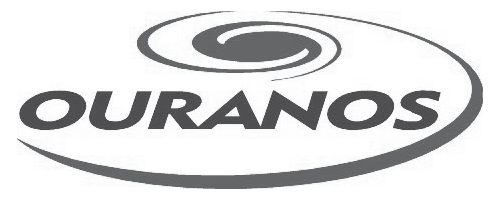

In [57]:
view_list = ["Série temporelle", "Tableau", "Carte"]
cols = {"rcp26": "blue", "rcp45": "green", "rcp85": "red"}
back_menu = "WhiteSmoke"

tab_ts  = None
tab_tbl = None
tab_map = None

# notebook:
output_mode = "jupyter_notebook"
if output_mode == "jupyter_notebook":

    logo_oura = pn.Column(pn.pane.PNG("./data/ouranos.png", height=50))
    
    views = pnw.RadioBoxGroup(name="RadioBoxGroup", options=view_list, inline=False)
    views.param.watch(views_update, ["value"], onlychanged=True)
    
    vars = pnw.Select(options=get_var_or_idx_list("ts"), width=100)
    vars.param.watch(vars_update, ["value"], onlychanged=True)
    
    plot = plot_ts(vars.value)
    tbl = build_tbl(vars.value)

    tab_ts  = pn.Row(pn.Column(pn.pane.Markdown("<b>Variable</b>"),
                               vars, plot))
    tab_tbl = pn.Row(pn.Column(pn.pane.Markdown("<b>Variable</b>"),
                               vars, tbl))
    tab_map = pn.Row(pn.Column(pn.pane.Markdown("<b>Variable</b>"),
                               vars, "Under development"))
    menu = pn.Column(logo_oura,
                     pn.pane.Markdown("<b>Select view</b>"),
                     views,
                     pn.Spacer(background=back_menu, sizing_mode="stretch_both"),
                     background=back_menu,
                     width=200)
    dash = pn.Row(menu, tab_ts)
    # The following line needs to be removed in streamlit.
    display(dash)

# streamlit:
else:
    
    logo_oura = Image.open("./data/ouranos.png")
    st.sidebar.image(logo_oura, width=150)
    
    views = st.sidebar.radio("Select view", view_list)
    
    if views == view_list[0]:
        vars = st.selectbox("Variable", options=get_var_or_idx_list("ts"))
        st.write(plot_ts(vars))
    elif views == view_list[1]:
        vars = st.selectbox("Variable", options=get_var_or_idx_list("tbl"))
        st.table(build_tbl(vars))
    else:
        vars = st.selectbox("Variable", options=get_var_or_idx_list("map"))